In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import *
from sklearn.metrics import recall_score, f1_score
np.set_printoptions(threshold=np.nan)
import pickle
import matplotlib.pyplot as plt

C:\Users\achindha\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Importing stationarized data
df1 = pd.read_csv('data.csv', delimiter=',',names = ['time', 'data (microvolts)'])

In [3]:
df1.head()

,time,data (microvolts)
0,0.027343,-18.651133
1,0.029296,-12.948667
2,0.031250,-8.075133
3,0.033203,-4.310333
4,0.035156,-1.728000


In [4]:
#Interchanging rows and columns of the data vector
df2 = df1['data (microvolts)'].T
mat=pd.DataFrame.as_matrix(df2)
N = len(mat)

In [7]:
#Labeling the data based on CAP_start and CAP_duration obtained from .m file
datafile = open('n1.data', 'r')
hypfile = open('hyp.csv', 'w')
intervfile = open('interv_file.csv','w')
durfile = open('dur_file.csv','w')
timelist = np.genfromtxt('time_tot.csv')
timearr = np.asarray(timelist)
durlist = np.genfromtxt('duration.csv')
durarr = np.asarray(durlist)
interval = 0.0019531 #specified in data file

numintervals = 1/interval
intervarr = numintervals * timearr
durationarr = numintervals * durarr

#READING AND STORING DATA:
lno = 0
j = 0
labvector = np.empty([N,1])
for line in datafile:
    lno += 1
    if (lno > 2 and j < len(durlist)):
        linelist = line.split('\t')
        data_interval = linelist[0]
        microvolts = linelist[3]
        label = 0
        if((int(intervarr[j]) <= int(data_interval)) and (int(data_interval) <= (int(intervarr[j]) + int(durationarr[j])))) :
            label = 1
            if (int(data_interval) == (int(intervarr[j]) + int(durationarr[j]))):
                j = j+1
        labvector[lno] = label    

datafile.close()
hypfile.close()
intervfile.close()
durfile.close()

In [8]:
#Allocating feature matrix and label_vector of appropriate dimensions 
w = 1536
p = 1276
rem = (N-w+2) % p
div = int ((N-w+2) / p) 
mat2 = np.zeros((div,w)) #Feature matrix
newlabvector = np.zeros(div) #Label vector

#New size of matrix= div x w

In [9]:
#Creating feature matrix from data for input to logistic regression:
j = 0
for i in range(0,N,p):
    if (j >= div):
        break
    mat2[j] =mat[i:i+w]
    j=j+1
    
j=0
for i in range(0,N,p):
    if (j >= div):
        break
    newlabvector[j]=labvector[i+w]
    j = j+1

In [10]:
#Assigning test and training splits.
percent_test_split = 0.3
train_size = int(div * (1 - percent_test_split))
test_size = int(div * percent_test_split)

In [11]:
#Train_data and test_data
Xtrain = mat2[0:train_size]
Ytrain = newlabvector[0:train_size]
Xtest = mat2[train_size:-1]
Ytest = newlabvector[train_size:-1]

In [12]:
#Creating logistic regression object
lreg = LogisticRegression(C=0.01, fit_intercept = True, solver = 'newton-cg', n_jobs = -1, class_weight = 'balanced')

In [13]:
#Training logistic regression on Xtrain and Ytrain
y_score = lreg.fit(Xtrain, Ytrain).decision_function(Xtest)

In [14]:
#Predicting labels for Xtest
Ypred_test = lreg.predict(Xtest)

In [15]:
print('Accuracy of logistic regression on test set: {:.2f}'.format(lreg.score(Xtest, Ytest)))

Accuracy of logistic regression on test set: 0.57


In [16]:
print('ROC AUC:%0.3f' %roc_auc_score(y_true=Ytest,y_score=Ypred_test))

ROC AUC:0.512


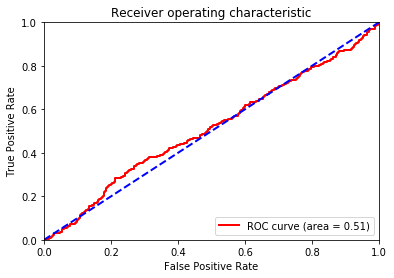

In [17]:
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(Ytest, y_score)
roc_auc[0] = auc(fpr[0], tpr[0])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()